In [39]:
import tensorflow as tf
from PIL import Image 
import numpy as np
import glob 
import random
import cv2
import os 

In [40]:
import matplotlib.pyplot as plt

def visualize(original, augmented, figure_size=(10,5)):
    fig = plt.figure(figsize=figure_size)
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis("off")

In [42]:
class DataReader(object):
    def __init__(self, bayer_dir, img_size=(324, 324)):
        self.bayer_dir = bayer_dir
        self.bayers = glob.glob(f"{bayer_dir}/*.bayer")
        self.num_bayers = len(self.bayers)
        self.img_h, self.img_w = img_size
        
    def __len__(self):
        return self.num_bayers
    
    def isp_it3(self, bayer):
        bayer = (bayer/255).astype(np.float32)
        black_level = 6/255
        white_level = 68/255
        bayer = (bayer - black_level) / (white_level - black_level)
        bayer = bayer * white_level
        bayer = np.clip(bayer, 0.0, 1.0)
        #red channel
        bayer[1::2,1::2] = bayer[1::2,1::2]
        #blue channel
        bayer[::2,::2] = bayer[::2,::2] * 1.25
        bayer = bayer * 2.5
        bayer = np.clip(bayer, None, 0.18)
        bayer = np.array(bayer * 255, dtype=np.uint8)
        img_rgb = cv2.cvtColor(bayer, cv2.COLOR_BAYER_RG2BGR)
        img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
        return img_rgb
    
    def bayer_to_jpg(self, bayer):
        # bayer to jpg 
        bayer_data = open(bayer, 'rb')
        bayer_np = np.fromfile(bayer_data, dtype=np.uint8)
        bayer_np = bayer_np.reshape(self.img_h, self.img_w)
        bayer_np = self.isp_it3(bayer_np)
        bayer_np = np.array(255 * (bayer_np / 255) ** 0.65, dtype='uint8')
        return bayer_np
    
    def load_bayer(self, bayer):
        bayer = tf.io.read_file(bayer)
        bayer = tf.io.decode_raw(bayer, tf.uint8)
        bayer = tf.reshape(bayer, (self.img_h, self.img_w, 1))
        return bayer
    
    def __getitem__(self, index):
        
        bayer = self.load_bayer(self.bayers[index])
        jpg = self.bayer_to_jpg(self.bayers[index])
        
        return bayer, jpg
    
    
    def iter(self):
        for i in range(self.num_bayers):
            yield self[i]

In [43]:
bayer_dir = "/bayer/cam0"
dataReader = DataReader(bayer_dir)

(324, 324, 1)
(324, 324, 3)


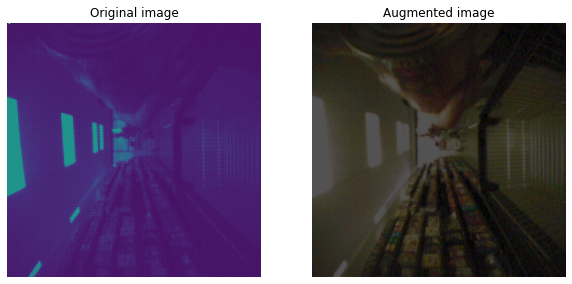

In [44]:
for bayer1, jpg1 in dataReader:
    print(bayer1.shape)
    print(jpg1.shape)
    visualize(bayer1, jpg1)
    break

In [51]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization,Activation, MaxPool2D, Concatenate
from tensorflow.keras.models import Model

def build_net(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=16, kernel_size=2, strides=1, padding="same", activation='relu', use_bias=True)(inputs)
    outputs = Conv2D(filters=3, kernel_size=2, strides=1, padding="same", activation='relu', use_bias=True)(x)
    model = Model(inputs, outputs, name="Debayer")
    return model

In [55]:
from tensorflow.keras import backend as K
"""
Loss function and metrics
"""
def jaccard_coefficient(y_true, y_pred, smooth=1.):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection
    return (intersection + smooth) / (union + smooth)


def jaccard_loss(y_true, y_pred):
    return 1 - jaccard_coefficient(y_true, y_pred)


def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

In [56]:
batch_size = 16
AUTOTUNE = tf.data.experimental.AUTOTUNE
dataset = tf.data.Dataset.from_generator(dataReader.iter,
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes=([324, 324, 1], [324, 324, 3]))
dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)

In [57]:
# train 
model = build_net(input_shape=(324,324,1))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=jaccard_loss, metrics=[jaccard_coefficient])

In [58]:
history = model.fit(dataset, epochs=10)

Epoch 1/10
816/816 [==============================] - 1286s 2s/step - loss: 2.1793 - jaccard_coefficient: -1.1792
Epoch 2/10
816/816 [==============================] - 741s 908ms/step - loss: 2.0415 - jaccard_coefficient: -1.0415
Epoch 3/10
816/816 [==============================] - 740s 907ms/step - loss: 2.0332 - jaccard_coefficient: -1.0332
Epoch 4/10
816/816 [==============================] - 742s 909ms/step - loss: 2.0293 - jaccard_coefficient: -1.0293
Epoch 5/10
720/816 [=========================>....] - ETA: 1:27 - loss: 2.0271 - jaccard_coefficient: -1.0271

KeyboardInterrupt: 

In [5]:
# export to edgetpu 

In [6]:
# try to load weights 

In [7]:
# include in other models 